In [16]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

from numba import cuda

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

In [10]:
images_dir = '/home/phm/Images/Stardist/'
X = sorted(glob(images_dir+'Test/Camille_Dapi_small/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

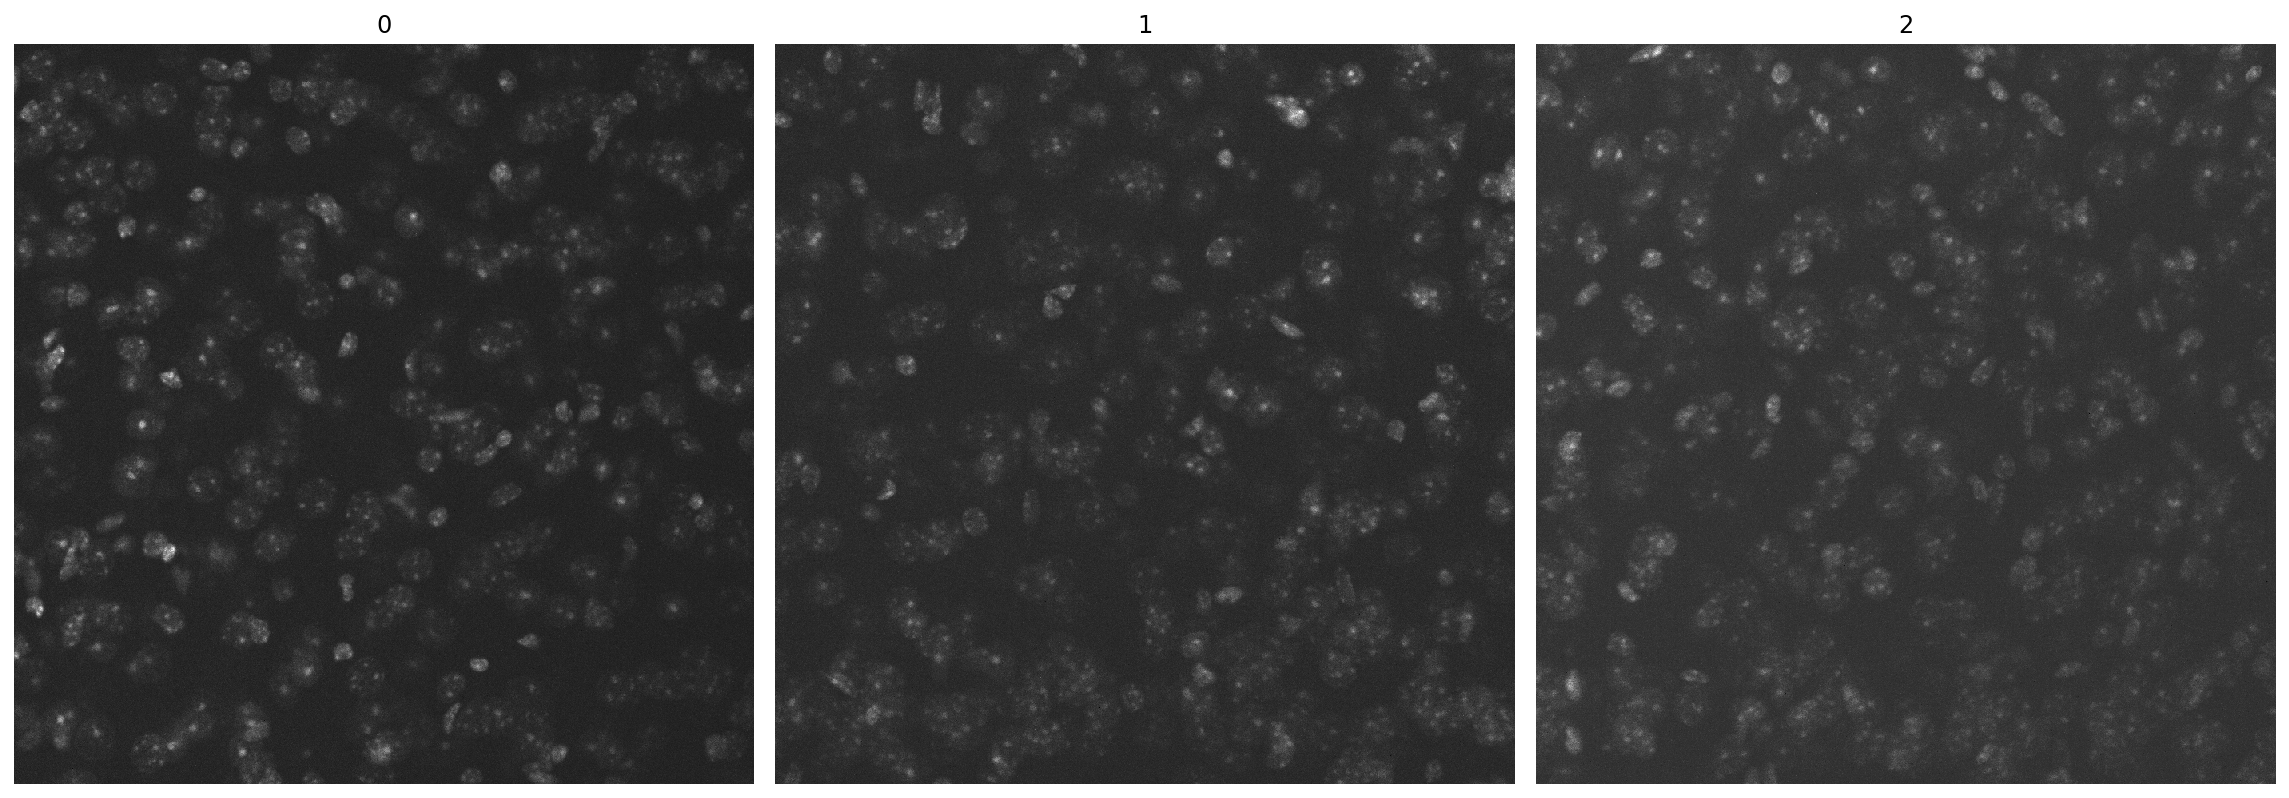

In [11]:
# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load versatile StarDist model

In [12]:
model = StarDist3D(None, name='Fluo3D', basedir='/home/phm/Developpement/StarDist_Models/3D')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.516831, nms_thresh=0.3.


# Plot some images

In [13]:
def example(model, i, show_dist=True):
    cuda.select_device(0)
    cuda.close()
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

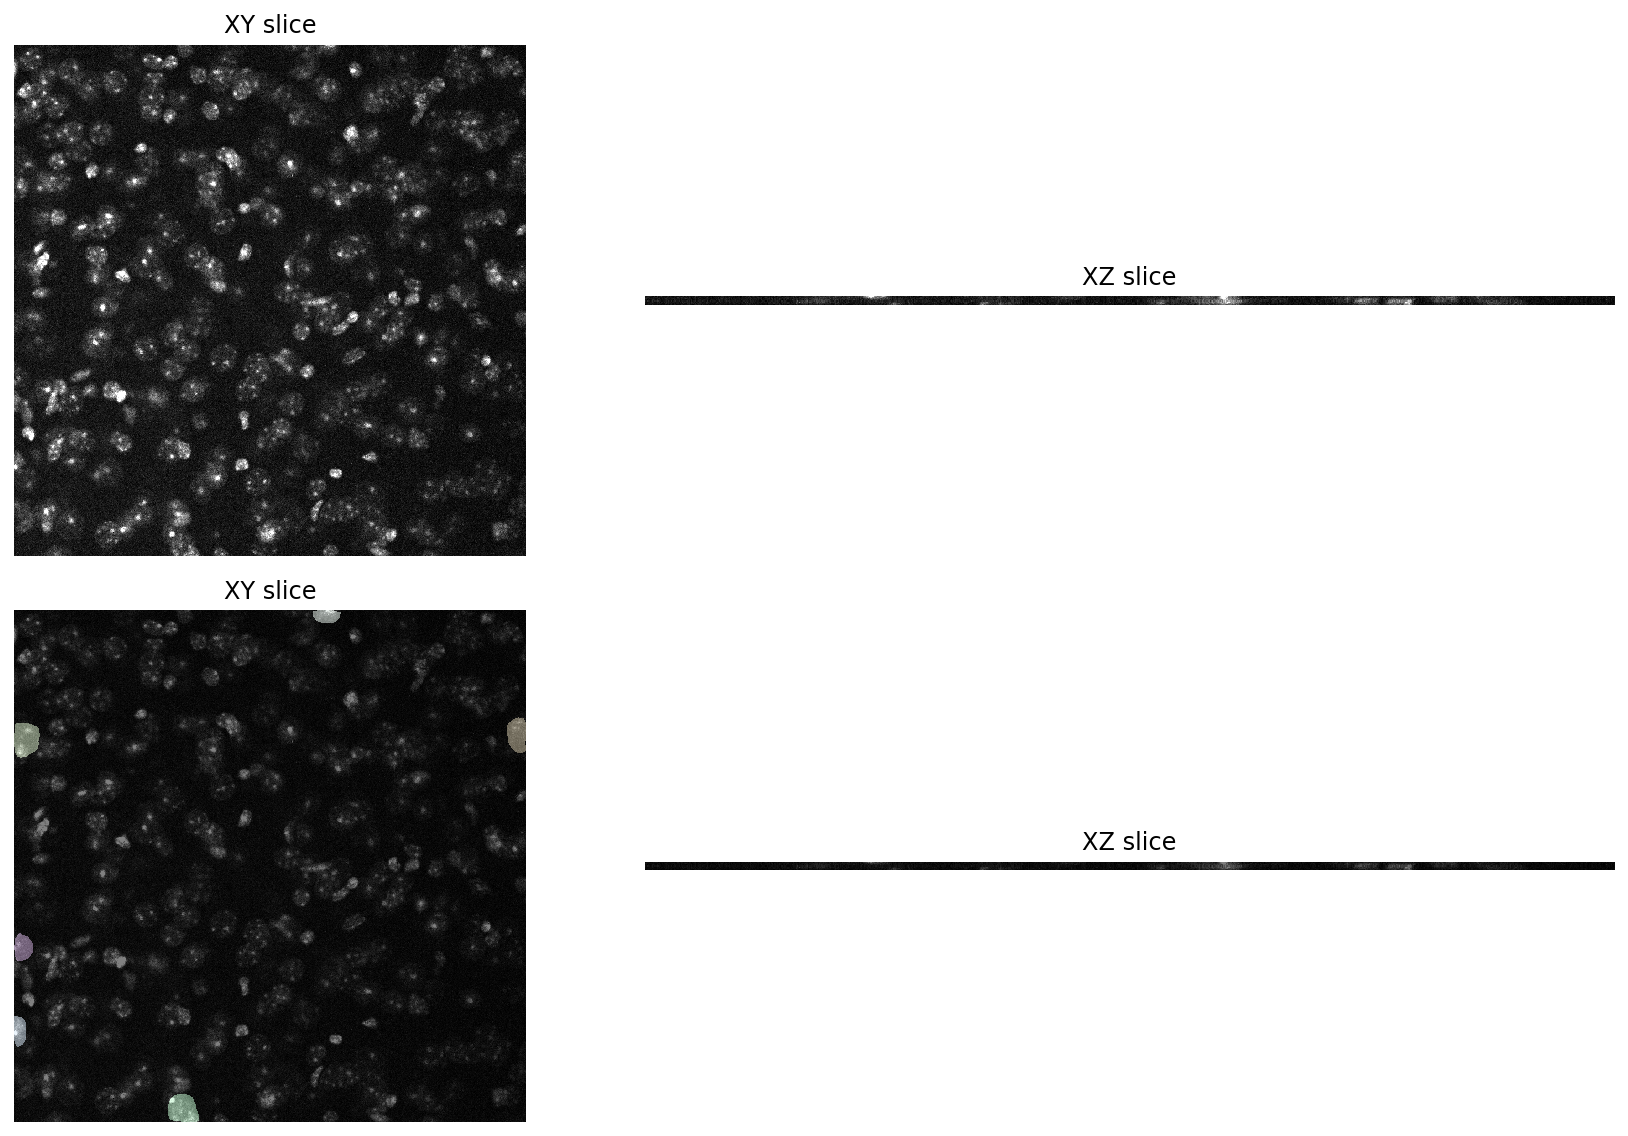

In [17]:
example(model, 0)

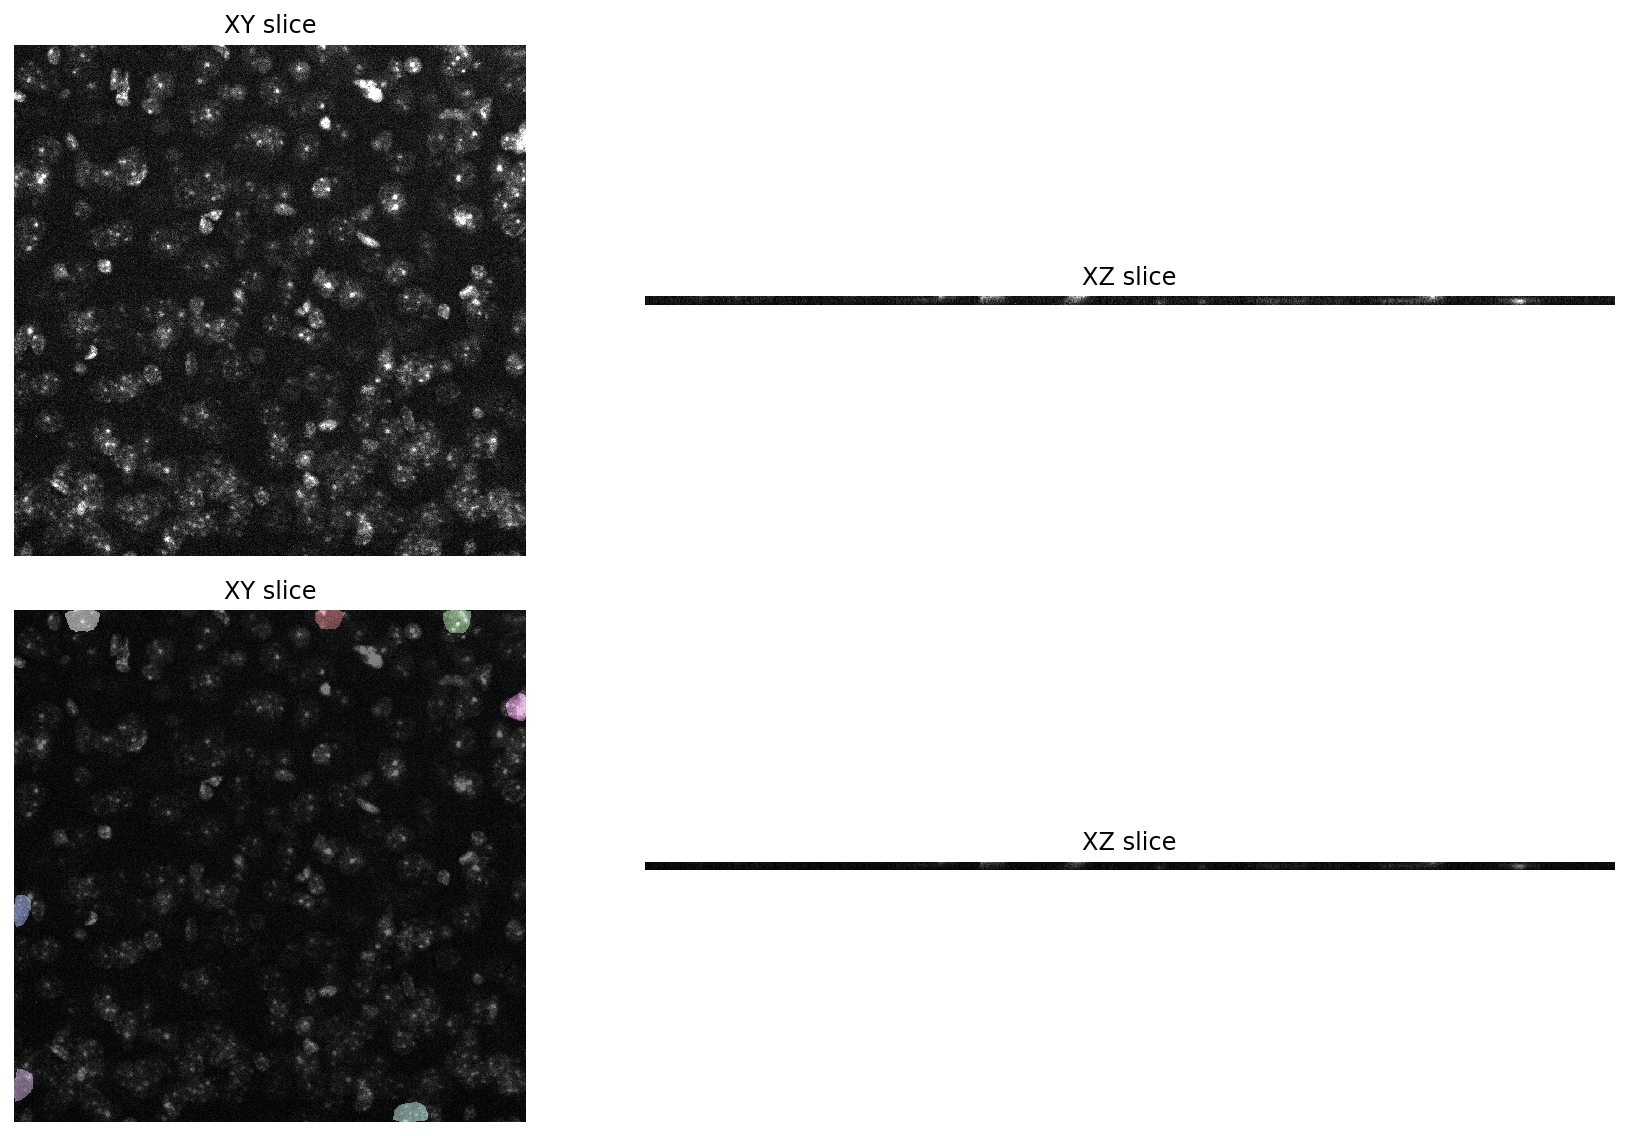

In [18]:
example(model, 1)

# Normalize, get labels and save

In [19]:
def save(model, i):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    save_tiff_imagej_compatible('example_labels.tif', labels, axes='ZYX')
   

In [24]:
from numba import cuda
cuda.select_device(0)
cuda.close()
for i in len(X):
    save(model,i)

TypeError: 'int' object is not iterable

<img src="https://github.com/mpicbg-csbd/stardist/raw/master/images/imagej_rois.png" style="height: 500px">